# Data Science Project 3

- Student Name: Natalya Doris
- Student Pace: Flex / 40 weeks
- Scheduled Project Review Date / Time: 
- Instructor Name: Abhineet Kulkarni
- Blog Post URL: 

## Setup, EDA, Preprocessing

In [949]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, \
MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### Load in Data

In [1051]:
df = pd.read_csv('data/investments_VC.csv', encoding = "ISO-8859-1")

### Basic Cleaning

In [1052]:
# getting rid of extra spaces in market and funding_total_usd
df = df.rename(columns={' market ': 'market', 
                            ' funding_total_usd ': 'funding_total_usd'})

Dropping irrelevant columns:

In [1053]:
df = df.drop(columns=['permalink', 'homepage_url', 'category_list', 
                          'founded_quarter', 'post_ipo_equity',  
                          'post_ipo_debt', 'secondary_market'], 
                 axis=1)

Dropping duplicates, if any:

In [1054]:
df = df.drop_duplicates()

### Acquired & Closed

In [1016]:
data['status'].value_counts()

operating    41829
acquired      3692
closed        2603
Name: status, dtype: int64

In [1017]:
#data_ac = data[data['status'] != 'operating']

### Exploratory Analysis - Full Dataset

In [945]:
data = df

In [ ]:
print(data.info())
data.head()

In [946]:
data['status'].value_counts()

operating    41829
acquired      3692
closed        2603
Name: status, dtype: int64

In [1000]:
data.isnull().sum()

name                        2
market                   3969
funding_total_usd           1
status                   1315
country_code             5274
state_code              19278
region                   5274
city                     6117
funding_rounds              1
founded_at              10885
founded_month           10957
founded_year            10957
first_funding_at            1
last_funding_at             1
seed                        1
venture                     1
equity_crowdfunding         1
undisclosed                 1
convertible_note            1
debt_financing              1
angel                       1
grant                       1
private_equity              1
product_crowdfunding        1
round_A                     1
round_B                     1
round_C                     1
round_D                     1
round_E                     1
round_F                     1
round_G                     1
round_H                     1
dtype: int64

In [482]:
data['founded_at'].head()

0    2012-06-01
1           NaN
2    2012-10-26
3    2011-04-01
4    2014-01-01
Name: founded_at, dtype: object

In [12]:
data['region'].value_counts()

SF Bay Area      6804
New York City    2577
Boston           1837
London           1588
Los Angeles      1389
                 ... 
Wetzlar             1
West End            1
Enfield Lock        1
GTM - Other         1
Ilford              1
Name: region, Length: 1089, dtype: int64

In [171]:
data['city'].value_counts()

na                      5856
San Francisco           2576
New York                2291
London                  1227
Palo Alto                586
                        ... 
Cantemir                   1
Laupheim                   1
Richmond Upon Thames       1
Cave City                  1
Barrowford                 1
Name: city, Length: 4128, dtype: int64

In [172]:
data['state_code'].value_counts()

na    18573
CA     9732
NY     2858
MA     1937
TX     1436
      ...  
MB       13
AK       12
NB        8
SK        4
PE        2
Name: state_code, Length: 62, dtype: int64

In [173]:
data['country_code'].value_counts()

USA    28233
na      5066
GBR     2595
CAN     1351
CHN     1229
       ...  
LIE        1
JAM        1
UZB        1
MAF        1
MUS        1
Name: country_code, Length: 116, dtype: int64

In [13]:
data['secondary_market'].value_counts()

0.0            49419
200000000.0        1
7343789.0          1
20000000.0         1
12500000.0         1
126700000.0        1
680611554.0        1
400000000.0        1
63750000.0         1
19300000.0         1
4700000.0          1
78800355.0         1
210000000.0        1
2500000.0          1
156929.0           1
700000.0           1
7718867.0          1
6192396.0          1
210000.0           1
60000000.0         1
Name: secondary_market, dtype: int64

In [481]:
# inspecting market feature - lots of catgories
print("Number of unique markets: ", len(set(data['market'])))
print("Markets with more than 200 companies: ",      
      str(sum(data['market'].value_counts() >= 200)))

Number of unique markets:  754
Markets with more than 200 companies:  39


<AxesSubplot:>

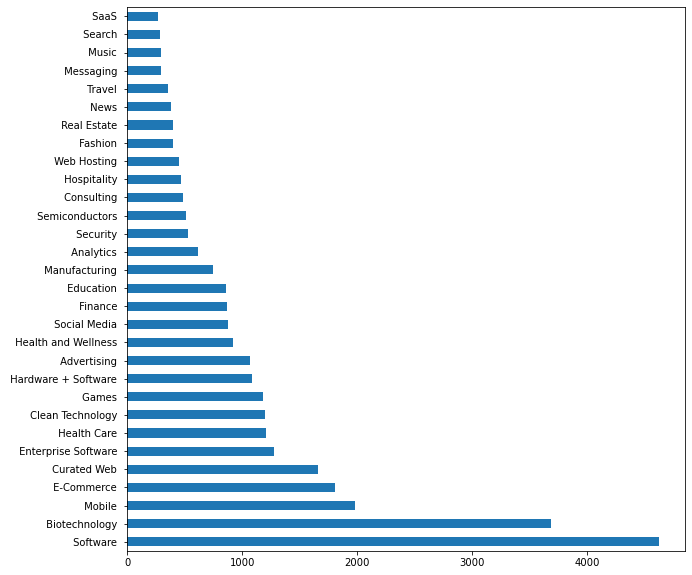

In [482]:
fig, ax = plt.subplots(figsize = (10,10))
data['market'].value_counts()[:30].plot(kind='barh')

In [483]:
# same deal with region
print("Number of unique regions: ", len(set(data['region'])))
print("Regions with more than 200 companies: ",      
      str(sum(data['region'].value_counts() >= 200)))

Number of unique regions:  1090
Regions with more than 200 companies:  44


<AxesSubplot:>

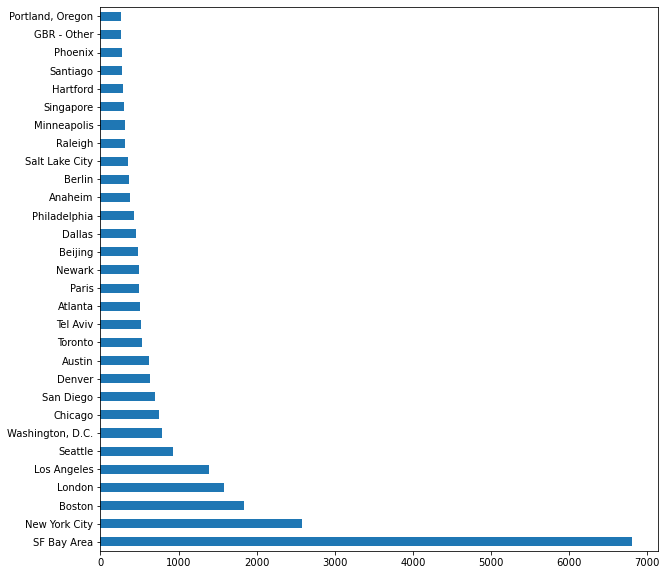

In [484]:
fig, ax = plt.subplots(figsize = (10,10))
data['region'].value_counts()[:30].plot(kind='barh')

In [9]:
# very few companies with post ipo equity
data['status'][data['post_ipo_equity'] > 0].value_counts()

operating    247
acquired       7
closed         2
Name: status, dtype: int64

In [10]:
# if a company got equity post ipo, that means they did not close
# therefore this variable probably not helpful to my model
data['status'][data['post_ipo_debt'] > 0].value_counts()

operating    59
acquired      2
Name: status, dtype: int64

array([[<AxesSubplot:title={'center':'equity_crowdfunding'}>]],
      dtype=object)

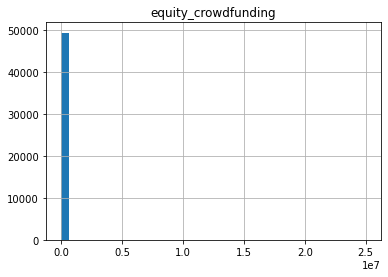

In [17]:
data.hist('equity_crowdfunding', bins=40)

### Preprocessing & Feature Engineering

In [12]:
data.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')

#### Missing Values

Removing rows with missing status or name. I am also dropping rows with a missing founded_year because this feature has high importance in many of the models & thus would prefer not to impute at risk of skewing the model. Proportion of companies in each status category & model results are fairly similar with & without imputing the median of year so I am comfortable dropping these rows.

In [1018]:
data = data.dropna(subset=['status', 'name', 'founded_year']) # adding founded year
data.isnull().sum()

name                        0
market                   1801
funding_total_usd           0
status                      0
country_code             2936
state_code              13332
region                   2936
city                     3357
funding_rounds              0
founded_at                  0
founded_month               0
founded_year                0
first_funding_at            0
last_funding_at             0
seed                        0
venture                     0
equity_crowdfunding         0
undisclosed                 0
convertible_note            0
debt_financing              0
angel                       0
grant                       0
private_equity              0
product_crowdfunding        0
round_A                     0
round_B                     0
round_C                     0
round_D                     0
round_E                     0
round_F                     0
round_G                     0
round_H                     0
dtype: int64

In [1002]:
len(data)

37563

In [1019]:
# filling categoricals
data = data.fillna(value={'market': 'other', 'country_code': 'other', 
                          'region': 'other', 'city': 'other', 
                          'state_code': 'other'})
#'founded_year': 0, 'founded_at': 'na'

10th percentile of founded_year:  2000.0
Num Rows before 2000:  3518


34045

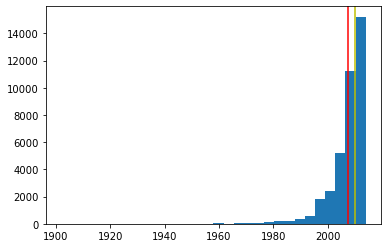

In [1020]:
# distribution of non NA years 
plt.hist(data['founded_year'][~data['founded_year'].isnull()], bins=30)
plt.axvline(x=np.nanmean(data['founded_year']), color='r')
plt.axvline(x=np.nanmedian(data['founded_year']), color='y')

p10 = np.percentile(data['founded_year'][~data['founded_year'].isnull()], 10)
print("10th percentile of founded_year: ", p10)

#10th percentile year is 2000, we will subset for startups founded on or after 2000
print("Num Rows before 2000: ", len(data[data['founded_year'] < 2000]))
data = data[data['founded_year'] >= 2000].reset_index(drop=True)
len(data)

Date data - convert to datetime:

In [1021]:
data['founded_at'] = [datetime.strptime(day, '%Y-%m-%d') for day \
                      in data['founded_at'][~data['founded_at'].isnull()]]
data['first_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                            in data['first_funding_at']]
data['last_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                            in data['last_funding_at']]
data['founded_month'] = [datetime.strptime(mth, "%Y-%m").month for mth in data['founded_month']]

Fill year & founded_at with simple imputer (only if not removing NaN rows). Since the data is skewed (see plot above), we will use median rather than mean.

In [636]:
# uncomment the below to impute founded_year with mean, only if we are not 
# dropping nans for this feature

#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

#data['founded_year'] = imp_median.fit_transform(data[['founded_year']])
#data['founded_at'] = imp_median.fit_transform(data[['founded_at']])

In [1022]:
data['founded_at'] = pd.to_datetime(data['founded_at'])
data['founded_year'] = [day.year for day in data['founded_at']]

In [1023]:
data['founded_at'].value_counts()

2012-01-01    2100
2011-01-01    2096
2010-01-01    1810
2009-01-01    1561
2013-01-01    1535
              ... 
2004-04-25       1
2009-08-12       1
2014-08-04       1
2002-08-02       1
2010-11-06       1
Name: founded_at, Length: 2935, dtype: int64

In [1007]:
data.isna().sum()

name                    0
market                  0
funding_total_usd       0
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
founded_month           0
founded_year            0
first_funding_at        0
last_funding_at         0
seed                    0
venture                 0
equity_crowdfunding     0
undisclosed             0
convertible_note        0
debt_financing          0
angel                   0
grant                   0
private_equity          0
product_crowdfunding    0
round_A                 0
round_B                 0
round_C                 0
round_D                 0
round_E                 0
round_F                 0
round_G                 0
round_H                 0
dtype: int64

Basic data cleaning:

In [1008]:
data.dtypes

name                            object
market                          object
funding_total_usd               object
status                          object
country_code                    object
state_code                      object
region                          object
city                            object
funding_rounds                 float64
founded_at              datetime64[ns]
founded_month                   object
founded_year                     int64
first_funding_at                object
last_funding_at                 object
seed                           float64
venture                        float64
equity_crowdfunding            float64
undisclosed                    float64
convertible_note               float64
debt_financing                 float64
angel                          float64
grant                          float64
private_equity                 float64
product_crowdfunding           float64
round_A                        float64
round_B                  

Getting rid of extra spaces in market, city, state code, region

In [1024]:
data['market'] = [x.strip() for x in data['market']]
data['country_code'] = [x.strip() for x in data['country_code']]
data['state_code'] = [x.strip() for x in data['state_code']]
data['region'] = [x.strip() for x in data['region']]
data['city'] = [x.strip() for x in data['city']]

In [1025]:
# need to convert this data type to integer
data['funding_total_usd'].value_counts()

 -               5632
 10,00,000        627
 1,00,000         582
 5,00,000         573
 40,000           466
                 ... 
 2,46,97,455        1
 15,42,386          1
 59,70,053          1
 9,88,17,742        1
 3,88,99,998        1
Name: funding_total_usd, Length: 10560, dtype: int64

In [1026]:
data['funding_total_usd'] = [float(num.replace(" ", "0").replace(",", "0").\
                                 replace("-", "0")) 
                             for num in data['funding_total_usd']]
data['funding_total_usd'].value_counts()

0.000000e+00    5632
1.000000e+09     627
1.000000e+08     582
5.000000e+08     573
4.000000e+06     466
                ... 
4.012089e+11       1
1.003021e+11       1
1.003016e+11       1
1.003013e+11       1
1.909503e+09       1
Name: funding_total_usd, Length: 10560, dtype: int64

In [639]:
#data['founded_quarter'] = [qtr[-2:] for qtr in data['founded_quarter']]
#data['founded_quarter'].head()

#### Feature Engineering

In [797]:
# creating column that labels country as domestic or international
data['international'] = [0 if country=='USA' else 1 for country in data['country_code']]

In [798]:
# creating temporary columns to aid in calcuation of time to first funding

data['founded_at_temp'] = [day.date() for day in data['founded_at']]
data['founded_at_temp'] = pd.to_datetime(data['founded_at_temp'], 
                                         format = '%Y-%m-%d')

data['first_funding_at_temp'] = pd.to_datetime(data['first_funding_at'], 
                                               format = '%Y-%m-%d', 
                                               errors='coerce')
data['last_funding_at_temp'] = pd.to_datetime(data['last_funding_at'], 
                                              format = '%Y-%m-%d', 
                                              errors='coerce')

data['time_to_first_funding'] = (data['first_funding_at_temp'] - \
                                 data['founded_at_temp']) / pd.Timedelta(days=365)

data['time_first_to_last_funding'] = (data['last_funding_at_temp'] - \
                                      data['first_funding_at_temp']) / pd.Timedelta(days=365)

In [799]:
# checking for nulls
print(data['first_funding_at'][data['time_to_first_funding'].isnull()])
print(data['last_funding_at'][data['time_first_to_last_funding'].isnull()])

1030     0020-06-14
4514     0019-11-20
9863     0201-01-01
20287    0007-05-13
21784    0001-05-14
Name: first_funding_at, dtype: object
1030     2013-06-01
4514     2013-04-01
9863     0201-01-01
20287    2014-09-25
21784    0001-05-14
Name: last_funding_at, dtype: object


#### OPTIONAL - Outliers

408206869399.0
32338
34040


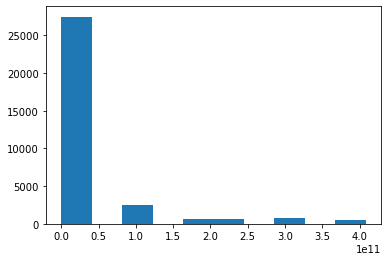

In [718]:
### THIS DOESNT HELP MODEL, IGNORE THIS SECTION

# Funding total USD
print(np.percentile(data['funding_total_usd'], 95))

plt.hist(data['funding_total_usd'][data['funding_total_usd'] < 408206869399.0])
print(len(data[data['funding_total_usd'] < 408206869399.0]))
print(len(data))
#plt.hist(data['venture'], bins=30)

32301
31990
34040


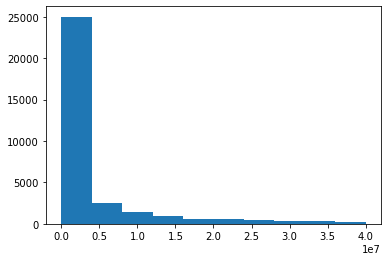

In [717]:
np.percentile(data['venture'], 95)

plt.hist(data['venture'][data['venture'] < 40000000.0])
print(len(data[data['venture'] < 40000000.0]))
print(len(data[(data['venture'] < 40000000.0) & 
               (data['funding_total_usd'] < 408206869399.0)]))
print(len(data))

In [719]:
# removing outliers

data = data[(data['venture'] < 40000000.0) & 
            (data['funding_total_usd'] < 408206869399.0)].reset_index(drop=True)
len(data)

31990

#### Correlations

Based on the below, the strongest correlations occur between debt_financing and funding_total_usd, round_H and round_G, followed by venture and all of the rounds of funding

Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Status)')

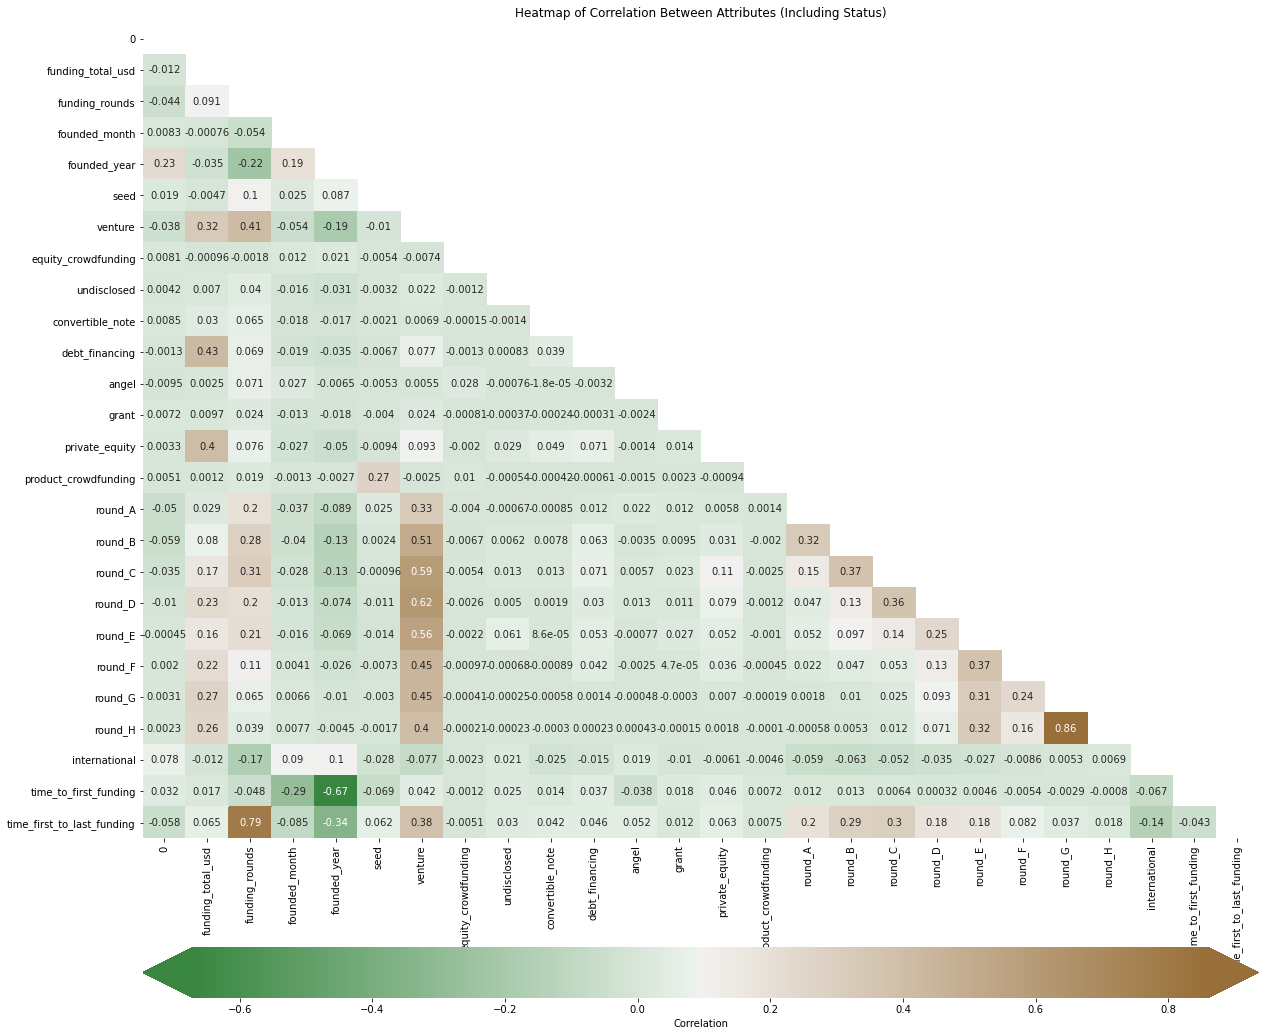

In [800]:
# with status
encoder = LabelEncoder()
heatmap_data = pd.concat([pd.Series(encoder.fit_transform(data['status'])), 
                          data.drop('status', axis=1)], axis=1)

# without status
#heatmap_data = data.drop('status', axis=1)

h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Status)')

In [649]:
#data_corr=data.drop(columns=['status'], axis=1).corr()
corr = h_corr.abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.set_index(['pairs'], inplace = True)
corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr.columns = ['cc']
corr.drop_duplicates(inplace=True)

corr[(corr['cc'] > 0.7) & (corr['cc'] < 1)]

In [802]:
# dropping rows with null since it's so few, dropping temp columns, 
# and columns with correlation coefficient greater than 0.7
data = data.dropna(subset=['time_to_first_funding'])
data = data.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                          'first_funding_at_temp', 'last_funding_at_temp', 
                          'founded_at_temp', 'round_H', 
                          'time_first_to_last_funding'], 
                 axis=1).reset_index(drop=True)


#### TEMP - Investigating Funding total

In [ ]:
# what is funding total?
# other funding components?

#### OPTIONAL - Binary Representation of Funding Rounds

In [497]:
data['had_round_A'] = [0 if x==0 else 1 for x in data['round_A']]
data['had_round_B'] = [0 if x==0 else 1 for x in data['round_B']]
data['had_round_C'] = [0 if x==0 else 1 for x in data['round_C']]
data['had_round_D'] = [0 if x==0 else 1 for x in data['round_D']]
data['had_round_E'] = [0 if x==0 else 1 for x in data['round_E']]
data['had_round_F'] = [0 if x==0 else 1 for x in data['round_F']]
data['had_round_G'] = [0 if x==0 else 1 for x in data['round_G']]
data['had_venture'] = [0 if x==0 else 1 for x in data['venture']]
data['had_seed'] = [0 if x==0 else 1 for x in data['seed']]
data['had_eq_crowdfunding'] = [0 if x==0 else 1 for x in data['equity_crowdfunding']]
data['had_pd_crowdfunding'] = [0 if x==0 else 1 for x in data['product_crowdfunding']]
data['had_angel'] = [0 if x==0 else 1 for x in data['angel']]
data['had_grant'] = [0 if x==0 else 1 for x in data['grant']]
data['had_pe'] = [0 if x==0 else 1 for x in data['private_equity']]
data['had_convert'] = [0 if x==0 else 1 for x in data['convertible_note']]

#### X/Y Split - All

Splitting out X and Y for train-test split:

In [804]:
len(data[data['status']=='closed'])

1893

In [805]:
# removing irrelevant columns w/ obvious correlations, lack of insight
X = data.drop(columns=['status', 'name', 'country_code', 'state_code', 
                       'city'], 
              axis=1)

# remove these if I go with binary version
#'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G'
#'undisclosed', 'angel' ,'grant', 'venture', 'equity_crowdfunding', 
# 'convertible_note', 'seed', 'private_equity', 'product_crowdfunding'

encoder = LabelEncoder()
y = pd.Series(encoder.fit_transform(data['status'])) 
# acquired is 0, closed is 1, operating is 2

# binary where 0 is acquired/operating(success), 1 is closed
y_bin = pd.Series([1 if val==1 else 0 for val in y])

In [806]:
print(y.value_counts(normalize=True))
y_bin.value_counts(normalize=True)

2    0.874589
0    0.069800
1    0.055611
dtype: float64


0    0.944389
1    0.055611
dtype: float64

In [748]:
X.dtypes

market                    object
region                    object
funding_rounds           float64
founded_month              int64
founded_year               int64
seed                     float64
venture                  float64
equity_crowdfunding      float64
undisclosed              float64
convertible_note         float64
debt_financing           float64
angel                    float64
grant                    float64
private_equity           float64
product_crowdfunding     float64
round_A                  float64
round_B                  float64
round_C                  float64
round_D                  float64
round_E                  float64
round_F                  float64
round_G                  float64
international              int64
time_to_first_funding    float64
dtype: object

In [807]:
# Transforming founded_year to float for one hot encoding
X['founded_year'] = [float(x) for x in X['founded_year']]
X['founded_month'] = [float(x) for x in X['founded_month']]
X.dtypes

market                    object
funding_total_usd        float64
region                    object
funding_rounds           float64
founded_month            float64
founded_year             float64
seed                     float64
venture                  float64
equity_crowdfunding      float64
undisclosed              float64
convertible_note         float64
debt_financing           float64
angel                    float64
grant                    float64
private_equity           float64
product_crowdfunding     float64
round_A                  float64
round_B                  float64
round_C                  float64
round_D                  float64
round_E                  float64
round_F                  float64
round_G                  float64
international              int64
time_to_first_funding    float64
dtype: object

#### X/Y Split - Closed or Acquired

In [915]:
# removing irrelevant columns w/ obvious correlations, lack of insight
data_ca = data[data['status'] != 'operating']
X_ca = data_ca.drop(columns=['status', 'name', 'country_code', 'state_code', 
                          'city'], 
                 axis=1)

# remove these if I go with binary version
#'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G'
#'undisclosed', 'angel' ,'grant', 'venture', 'equity_crowdfunding', 
# 'convertible_note', 'seed', 'private_equity', 'product_crowdfunding'

encoder = LabelEncoder()
y_ca = pd.Series(encoder.fit_transform(data_ca['status'])) 
# acquired is 0, closed is 1
y_ca.value_counts(normalize=True)

0    0.556571
1    0.443429
dtype: float64

In [916]:
len(X_ca)

4269

#### Feature Reduction (All) - Market, Region

In [808]:
sum(X['market'].value_counts() >= 100)

50

In [809]:
X['market'][X['market'].map(X['market'].value_counts()) < 100] = 'other'
X['market'].value_counts()

other                   10318
Software                 3138
Biotechnology            2014
Mobile                   1465
E-Commerce               1308
Curated Web              1257
Enterprise Software       911
Games                     832
Advertising               804
Health Care               742
Social Media              702
Hardware + Software       685
Clean Technology          660
Education                 596
Finance                   592
Health and Wellness       555
Analytics                 482
Manufacturing             408
Security                  348
Hospitality               330
Real Estate               318
Consulting                305
Fashion                   301
Semiconductors            294
Travel                    277
News                      276
Web Hosting               251
SaaS                      227
Search                    220
Messaging                 212
Music                     211
Sports                    209
Internet                  199
Medical   

In [811]:
sum(X['region'].value_counts() > 450) # top 10 regions

11

In [812]:
X['region'][X['region'].map(X['region'].value_counts()) <= 420] = 'other'
# combine na and low dens for 'other' category
X['region'].value_counts()

other               19618
SF Bay Area          5289
New York City        2089
Boston               1267
London               1202
Los Angeles          1050
Seattle               687
Washington, D.C.      532
Chicago               526
Denver                462
Austin                460
San Diego             435
Tel Aviv              423
Name: region, dtype: int64

#### Feature Reduction (Closed or Acquired)

In [921]:
sum(X_ca['market'].value_counts() >= 15)

47

In [922]:
X_ca['market'][X_ca['market'].map(X_ca['market'].value_counts()) < 15] = 'other'
X_ca['market'].value_counts()

other                    1009
Software                  426
Curated Web               336
Mobile                    255
Advertising               164
Games                     163
Enterprise Software       162
E-Commerce                148
Biotechnology             142
Social Media              132
Hardware + Software        81
Semiconductors             78
Security                   73
Clean Technology           68
Finance                    67
Web Hosting                67
Health Care                59
Analytics                  54
Search                     51
Messaging                  49
News                       45
Music                      40
Video                      38
Education                  37
Travel                     37
Networking                 36
Photography                35
Social Network Media       34
Public Relations           32
SaaS                       26
Sports                     25
Health and Wellness        22
Web Development            22
Internet  

In [926]:
sum(X_ca['region'].value_counts() > 60) # top 10 regions

12

In [927]:
X_ca['region'][X_ca['region'].map(X_ca['region'].value_counts()) <= 60] = 'other'
# combine na and low dens for 'other' category
X_ca['region'].value_counts()

other               1864
SF Bay Area         1114
New York City        319
Boston               211
Los Angeles          165
Seattle              128
London               126
Austin                76
Washington, D.C.      69
Tel Aviv              69
Denver                67
San Diego             61
Name: region, dtype: int64

### Train Test Split - Function

In [1370]:
def train_test_preprocess(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    #print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
    #print(f"y_train is a Series with {y_train.shape[0]} values")

    # Same number of rows in X as values in y
    assert X_train.shape[0] == y_train.shape[0]
    
    #print(y_train.value_counts(normalize=True))
    
    # Categorizing features in preparation for scaling / encoding
    X_train_cat_eng = X_train.select_dtypes(include=['int64']).reset_index(drop=True)
    X_test_cat_eng = X_test.select_dtypes(include=['int64']).reset_index(drop=True)

    X_train_cont = X_train.select_dtypes(exclude=['object','int64']).reset_index(drop=True)
    X_test_cont = X_test.select_dtypes(exclude=['object','int64']).reset_index(drop=True)

    cat_columns = ['market', 'region']
    cat_train = X_train[cat_columns].reset_index(drop=True)
    cat_test = X_test[cat_columns].reset_index(drop=True)

    # Scale continuous variables using Min Max Scaler:
    scaler = MinMaxScaler() # instantiate MinMaxScaler

    ## TRAIN
    # Fit and transform X_train
    X_train_cont_scaled = scaler.fit_transform(X_train_cont)
    X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

    # One hot encode categoricals
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    encoded_train = ohe.fit_transform(cat_train).toarray()
    X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

    # Putting it all together:
    X_train_processed = pd.concat([X_train_cat, X_train_cont, X_train_cat_eng], axis=1)
    X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled, X_train_cat_eng], axis=1) 

    ## TEST
    # Scale continuous features
    X_test_cont_scaled = scaler.transform(X_test_cont)
    X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

    # One hot encoding categoricals
    encoded_test = ohe.transform(cat_test).toarray()
    X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names(cat_test.columns))

    # Putting it all together
    X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled, X_test_cat_eng], axis=1)
    X_test_processed = pd.concat([X_test_cat, X_test_cont, X_test_cat_eng], axis=1)
    
    return X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test

In [936]:
X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test = train_test_preprocess(X_ca, y_ca)

X_train is a DataFrame with 3201 rows and 25 columns
y_train is a Series with 3201 values
0    0.556701
1    0.443299
dtype: float64


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,founded_month,founded_year,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12654999.0,21000000.0,26000000.0,0.0,0.0,0.0,1.328767,1,2006,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.010959,12,2009,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.331507,11,2011,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3900000.0,0.0,0.0,0.0,0.0,0.0,-3.926027,7,2011,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.652055,6,2011,0


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,founded_month,founded_year,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.036157,0.105,0.104,0.0,0.0,0.0,0.802574,1,2006,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.000,0.0,0.0,0.0,0.781153,12,2009,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.000,0.0,0.0,0.0,0.786363,11,2011,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.011143,0.000,0.000,0.0,0.0,0.0,0.717155,7,2011,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000,0.000,0.0,0.0,0.0,0.791574,6,2011,0


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,founded_month,founded_year,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.498630,7,2008,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.454795,1,2006,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10000000.0,0.0,0.0,0.0,0.0,0.0,4.758904,1,2004,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.747945,2,2010,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.232877,1,2006,0


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,founded_month,founded_year,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.772869,7,2008,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.773582,1,2006,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028571,0.0,0.0,0.0,0.0,0.0,0.858333,1,2004,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.809388,2,2010,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.833526,1,2006,0


In [937]:
df_corr=X_train_processed.corr()

df = df_corr.abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']
df.drop_duplicates(inplace=True)

df[(df.cc>.5) & (df.cc<1)]

,cc
pairs,
"(round_E, round_F)",0.734840
"(round_F, debt_financing)",0.721803
"(venture, round_B)",0.710362
"(venture, round_C)",0.672736
"(founded_year, time_to_first_funding)",0.640687
"(round_E, debt_financing)",0.598267
"(international, region_other)",0.578850
"(round_D, venture)",0.542664
"(round_A, round_B)",0.541239


### Train Test Split - OG

In [891]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, random_state=42) 
#can use y for multiclass, #y_bin for binary

In [892]:
print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

# Same number of rows in X as values in y
assert X_train.shape[0] == y_train.shape[0]

X_train is a DataFrame with 25530 rows and 25 columns
y_train is a Series with 25530 values


In [893]:
print(y_train.value_counts(normalize=True))

0    0.944888
1    0.055112
dtype: float64


In [894]:
X_train.columns

Index(['market', 'funding_total_usd', 'region', 'funding_rounds',
       'founded_month', 'founded_year', 'seed', 'venture',
       'equity_crowdfunding', 'undisclosed', 'convertible_note',
       'debt_financing', 'angel', 'grant', 'private_equity',
       'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D',
       'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding'],
      dtype='object')

### Preprocessing with Sklearn

In [895]:
# Categorizing features in preparation for scaling / encoding
X_train_cat_eng = X_train.select_dtypes(include=['int64']).reset_index(drop=True)
X_test_cat_eng = X_test.select_dtypes(include=['int64']).reset_index(drop=True)

X_train_cont = X_train.select_dtypes(exclude=['object','int64']).reset_index(drop=True)
X_test_cont = X_test.select_dtypes(exclude=['object','int64']).reset_index(drop=True)

cat_columns = ['market', 'region']
cat_train = X_train[cat_columns].reset_index(drop=True)
cat_test = X_test[cat_columns].reset_index(drop=True)

#### Preprocessing training data

In [896]:
# Scale continuous variables using Min Max Scaler:
scaler = MinMaxScaler() # instantiate MinMaxScaler

# Fit and transform X_train
X_train_cont_scaled = scaler.fit_transform(X_train_cont)
X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

# One hot encode categoricals
ohe = OneHotEncoder(handle_unknown = 'ignore')
encoded_train = ohe.fit_transform(cat_train).toarray()
X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

# Putting it all together:
X_train_processed = pd.concat([X_train_cat, X_train_cont, X_train_cat_eng], axis=1)
X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled, X_train_cat_eng], axis=1) 

display(X_train_processed.head())
display(X_train_scaled.head())

,market_Advertising,market_Analytics,market_Apps,market_Automotive,market_Big Data,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016438,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,20000000.0,0.0,0.0,0.0,0.0,0.0,0.0,4.054795,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.712329,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3300000.0,1300000.0,0.0,0.0,0.0,0.0,0.0,0.747945,0


,market_Advertising,market_Analytics,market_Apps,market_Automotive,market_Big Data,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.762904,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1000,0.000000,0.0,0.0,0.0,0.0,0.0,0.827574,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.763165,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.774480,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0165,0.002399,0.0,0.0,0.0,0.0,0.0,0.775046,0


In [851]:
X_train.dtypes

market                    object
funding_total_usd        float64
region                    object
funding_rounds           float64
founded_month            float64
founded_year             float64
seed                     float64
venture                  float64
equity_crowdfunding      float64
undisclosed              float64
convertible_note         float64
debt_financing           float64
angel                    float64
grant                    float64
private_equity           float64
product_crowdfunding     float64
round_A                  float64
round_B                  float64
round_C                  float64
round_D                  float64
round_E                  float64
round_F                  float64
round_G                  float64
international              int64
time_to_first_funding    float64
dtype: object

#### Correlation Check After OHE

In [897]:
df_corr=X_train_processed.corr()

df = df_corr.abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']
df.drop_duplicates(inplace=True)

df[(df.cc>.5) & (df.cc<1)]

In [898]:
df[(df.cc>.5) & (df.cc<1)] # correlation above 0.5

# same results as before, all good here

,cc
pairs,
"(founded_year, time_to_first_funding)",0.666708
"(venture, round_D)",0.629175
"(venture, round_E)",0.589557
"(round_C, venture)",0.565488
"(round_F, round_E)",0.551155
"(debt_financing, funding_total_usd)",0.508999
"(venture, round_G)",0.507842
"(funding_total_usd, venture)",0.503180


#### Preprocessing test data

In [899]:
# Scale continuous features
X_test_cont_scaled = scaler.transform(X_test_cont)
X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

# One hot encoding categoricals
encoded_test = ohe.transform(cat_test).toarray()
X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names(cat_test.columns))

# Putting it all together
X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled, X_test_cat_eng], axis=1)
X_test_processed = pd.concat([X_test_cat, X_test_cont, X_test_cat_eng], axis=1)

display(X_test_processed.head())
display(X_test_scaled.head())

,market_Advertising,market_Analytics,market_Apps,market_Automotive,market_Big Data,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,271043.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084932,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.542466,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.268493,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.665753,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.465753,1


,market_Advertising,market_Analytics,market_Apps,market_Automotive,market_Big Data,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.764514,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.994168,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.830969,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.773740,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.770563,1


In [900]:
print("There are {} features in train set".format(len(X_train_processed.columns)))
print("There are {} features in test set".format(len(X_test_processed.columns)))

There are 86 features in train set
There are 86 features in test set


In [901]:
print("There are {} features in train set (scaled)".format(len(X_train_scaled.columns)))
print("There are {} features in test set (scaled)".format(len(X_test_scaled.columns)))

There are 86 features in train set (scaled)
There are 86 features in test set (scaled)


### Feature Selection

In [735]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

X_10_best= SelectKBest(f_classif, k=10).fit(X_train_processed, y_train)
mask = X_10_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, X_train_processed.columns):
    if bool:
        new_feat.append(feature)
print('The best features (using f_classif score) are: {}'.format(new_feat)) 
# The list of 10 best features

ValueError: Found input variables with inconsistent numbers of samples: [25530, 23992]

## Baseline Model

Logistic regression:

In [902]:
baseline_model = LogisticRegression(random_state=42, class_weight='balanced')
baseline_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [903]:
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

In [904]:
print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85     24123
           1       0.15      0.76      0.26      1407

    accuracy                           0.76     25530
   macro avg       0.57      0.76      0.56     25530
weighted avg       0.94      0.76      0.82     25530

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      8024
           1       0.15      0.73      0.25       486

    accuracy                           0.75      8510
   macro avg       0.56      0.74      0.55      8510
weighted avg       0.93      0.75      0.81      8510



In [826]:
coef_df = pd.DataFrame(baseline_model.coef_, columns=X_train_scaled.columns)
coef_df.to_csv('coef_logreg_base.csv')

#### Function to Print Scores

In [1093]:
def print_scores(y_train, y_hat_train, y_test, y_hat_test, binary=True):
    if binary:
        print('Training Recall: ', 
              recall_score(y_train, y_hat_train))
        print('Testing Recall: ', 
              recall_score(y_test, y_hat_test))
        print('\n')
        print('Training F1: ', 
              f1_score(y_train, y_hat_train))
        print('Testing F1: ', 
              f1_score(y_test, y_hat_test))
        print('\n')
        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_hat_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print('ROC AUC: ', roc_auc)
        print('PR AUC: ', average_precision_score(y_test, y_hat_test))
        print('\n')
        
    else:
        print('Training Recall (weighted avg): ', 
              recall_score(y_train, y_hat_train, average='weighted'))
        print('Testing Recall (weighted avg): ', 
              recall_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training Recall (macro avg): ', 
              recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall (macro avg): ', 
              recall_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Training F1-Score (weighted avg): ', 
              f1_score(y_train, y_hat_train, average='weighted'))
        print('Testing F1-Score (weighted avg): ', 
              f1_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training F1-Score (macro avg): ', 
              f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score (macro avg): ', 
              f1_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Testing Recall (failure class): ', 
              recall_score(y_test, y_hat_test, average=None, labels=[1]))
        print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

#### Function to Return Scores - Binary

In [1182]:
def return_scores(y_train, y_hat_train, y_test, y_hat_test):
    r_train = recall_score(y_train, y_hat_train)
    r_test = recall_score(y_test, y_hat_test)
         
    f1_train = f1_score(y_train, y_hat_train)
    f1_test = f1_score(y_test, y_hat_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    pr_auc = average_precision_score(y_test, y_hat_test)
    
    ac_train = accuracy_score(y_train, y_hat_train)
    ac_test = accuracy_score(y_test, y_hat_test)
    
    return r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc

In [875]:
recall_score(y_test, y_hat_test, average=None)#, labels=[1,0])

array([0.56110155, 0.55967078, 0.69367191])

In [907]:
print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7604832977967306
Testing Recall:  0.7304526748971193


Training F1:  0.255827854154214
Testing F1:  0.24938531787846854


PR AUC:  0.12522453109693021


Training Accuracy:  0.7561692126909518
Testing Accuracy:  0.7488836662749706


## Other Models

### Logistic Regression

In [ ]:
# Grid search on baseline for hyperparameter tuning

In [769]:
param_grid = {'penalty':['l1', 'l2', None],
              'solver':['lbfgs', 'newton-cg', 'sag'],
              'C': [1.0, 1e12],
             }

In [770]:
# 3min runtime
grid_logreg = GridSearchCV(baseline_model, param_grid, cv = 5, 
                           scoring='average_precision') # macro or weighted
grid_logreg.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             param_grid={'C': [1.0, 1000000000000.0],
                         'penalty': ['l1', 'l2', None],
                         'solver': ['lbfgs', 'newton-cg', 'sag']},
             scoring='average_precision')

In [771]:
grid_logreg.best_params_ # recall, f1 same params

{'C': 1000000000000.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [772]:
y_preds_grid_lr = grid_logreg.predict(X_test_scaled)
print(classification_report(y_test, y_preds_grid_lr))
average_precision_score(y_test, y_preds_grid_lr)

              precision    recall  f1-score   support

           0       0.98      0.76      0.85      7552
           1       0.15      0.73      0.25       446

    accuracy                           0.75      7998
   macro avg       0.56      0.74      0.55      7998
weighted avg       0.93      0.75      0.82      7998



0.1246618252661721

In [908]:
# best logreg
logreg_best = LogisticRegression(random_state=42, class_weight='balanced', 
                                 C=1e12,  penalty='l2')
logreg_best.fit(X_train_scaled, y_train)
y_hat_train_2 = logreg_best.predict(X_train_scaled)
y_hat_test_2 = logreg_best.predict(X_test_scaled)

print_scores(y_train, y_hat_train_2, y_test, y_hat_test_2)
print(classification_report(y_train, y_hat_train_2))
print(classification_report(y_test, y_hat_test_2))

Training Recall:  0.7746979388770433
Testing Recall:  0.7407407407407407


Training F1:  0.2587537091988131
Testing F1:  0.2527202527202527


PR AUC:  0.1276570062122694


Training Accuracy:  0.7553858206032119
Testing Accuracy:  0.7498237367802585
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     24123
           1       0.16      0.77      0.26      1407

    accuracy                           0.76     25530
   macro avg       0.57      0.76      0.56     25530
weighted avg       0.94      0.76      0.82     25530

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      8024
           1       0.15      0.74      0.25       486

    accuracy                           0.75      8510
   macro avg       0.57      0.75      0.55      8510
weighted avg       0.93      0.75      0.82      8510



In [775]:
coef_df = pd.DataFrame(logreg_best.coef_, columns=X_train_scaled.columns)
coef_df.to_csv('coef_logreg_best.csv')

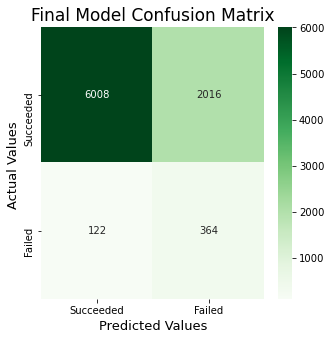

In [830]:
# visualizing predictions
conf_matrix = confusion_matrix(y_test, y_hat_test_2)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Final Model Confusion Matrix', fontsize=17);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Succeeded','Failed'])
ax.yaxis.set_ticklabels(['Succeeded','Failed'])


## Display the visualization of the Confusion Matrix.
plt.show()

### Random Forest

In [831]:
rfc = RandomForestClassifier(random_state=42, criterion='gini', 
                             min_samples_leaf=10, max_depth=5,
                             class_weight='balanced')

rfc.fit(X_train_processed, y_train)

y_hat_train_3 = rfc.predict(X_train_processed)
y_hat_test_3 = rfc.predict(X_test_processed)

print_scores(y_train, y_hat_train_3, y_test, y_hat_test_3)

Training Recall:  0.7107320540156361
Testing Recall:  0.6790123456790124


Training F1:  0.2389486260454002
Testing F1:  0.2335456475583864


PR AUC:  0.11408952616682085


Training Accuracy:  0.7504896200548374
Testing Accuracy:  0.745475910693302


In [108]:
# Tuning the model with grid search

param_grid = {'criterion':['gini','entropy','log_loss'],
              'max_depth':[3,8,12],
              'min_samples_leaf': [5,10],
              'class_weight': [None, 'balanced']
             }

In [110]:
## long run time

grid_rfc = GridSearchCV(rfc, param_grid, cv = 5, scoring='recall') 
# macro or weighted?
grid_rfc.fit(X_train_processed, y_train) #17 min execution

KeyboardInterrupt: 

In [119]:
grid_rfc.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 5}

In [120]:
y_preds_grid_rfc = grid_rfc.predict(X_test)

In [121]:
display(confusion_matrix(y_test, y_preds_grid_rfc))
print(classification_report(y_test, y_preds_grid_rfc))

array([[    0,     0,   923],
       [    0,     0,   678],
       [    0,     0, 10430]])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       923
           1       0.00      0.00      0.00       678
           2       0.87      1.00      0.93     10430

    accuracy                           0.87     12031
   macro avg       0.29      0.33      0.31     12031
weighted avg       0.75      0.87      0.81     12031



In [ ]:
# visualizing predictions
conf_matrix = confusion_matrix(y_test, y_preds_grid_rfc)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

# Title & Axis Labels
ax.set_title('Best RFC Model Confusion Matrix', fontsize=17);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

## Set tick labels
ax.xaxis.set_ticklabels(['Succeeded','Failed'])
ax.yaxis.set_ticklabels(['Succeeded','Failed'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### Feature Importance

In [342]:
#sorted(rfc.feature_importances_, reverse=True)[:20]
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, rfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

#importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
#importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)
    
feats_df = pd.DataFrame(feats.items())

In [343]:
feats_df.columns = ['col', 'feat_importance']
feats_df = feats_df.sort_values(by=['feat_importance'], ascending=False)
feats_df_20 = feats_df[:20]
feats_df_30 = feats_df[:30]

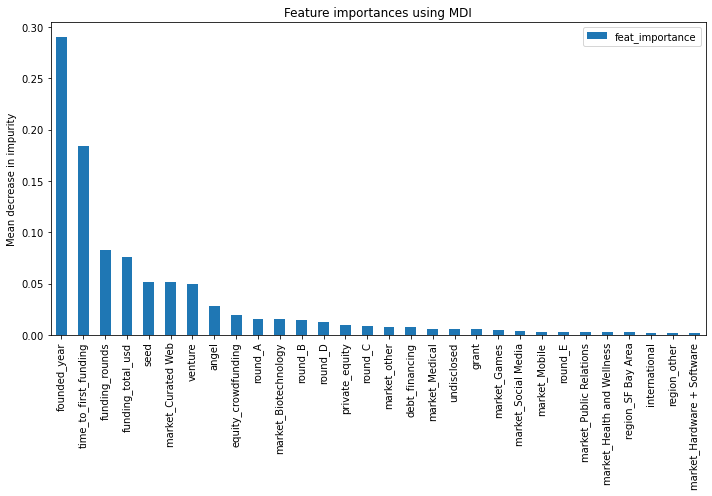

In [344]:
fig, ax = plt.subplots(figsize = (10,7))
feats_df_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_df_30['col'])
fig.tight_layout()

### Tree Models


#### Decision Tree Classifier**

This model seems to be the best compromise, with recall at around 80% and accuracy at 70% / PR AUC at 12%

In [909]:
dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                             min_samples_leaf=5, max_depth=10)
dtc.fit(X_train_processed, y_train)

y_hat_train_dtc = dtc.predict(X_train_processed)
y_hat_test_dtc = dtc.predict(X_test_processed)

print_scores(y_train, y_hat_train_dtc, y_test, y_hat_test_dtc)
print(classification_report(y_train, y_hat_train_dtc))
print(classification_report(y_test, y_hat_test_dtc))

Training Recall:  0.9303482587064676
Testing Recall:  0.7592592592592593


Training F1:  0.289505695012717
Testing F1:  0.24062601891098792


PR AUC:  0.12229818889522745


Training Accuracy:  0.7483352918135526
Testing Accuracy:  0.7263219741480611
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     24123
           1       0.17      0.93      0.29      1407

    accuracy                           0.75     25530
   macro avg       0.58      0.83      0.57     25530
weighted avg       0.95      0.75      0.82     25530

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      8024
           1       0.14      0.76      0.24       486

    accuracy                           0.73      8510
   macro avg       0.56      0.74      0.54      8510
weighted avg       0.93      0.73      0.80      8510



In [371]:
# Grid search
param_grid = {'criterion':['gini','entropy'],
              'max_depth':[None,3,8,12],
              'min_samples_leaf': [1,5,10,15],
              'class_weight': [None, 'balanced']
             }

grid_dtc = GridSearchCV(dtc, param_grid, cv = 5, scoring='recall') 
grid_dtc.fit(X_train_processed, y_train)
y_preds_grid_train_dtc = grid_dtc.predict(X_train_processed)
y_preds_grid_dtc = grid_dtc.predict(X_test_processed)

print(classification_report(y_test, y_preds_grid_dtc))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80      8024
           1       0.13      0.80      0.22       486

    accuracy                           0.68      8510
   macro avg       0.56      0.74      0.51      8510
weighted avg       0.93      0.68      0.77      8510



In [373]:
grid_dtc.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 15}

In [910]:
dtc_best = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                  min_samples_leaf=15, max_depth=8, 
                                  criterion='entropy')
dtc_best.fit(X_train_processed, y_train)

y_hat_train_dtc_best = dtc_best.predict(X_train_processed)
y_hat_test_dtc_best = dtc_best.predict(X_test_processed)

print_scores(y_train, y_hat_train_dtc_best, y_test, y_hat_test_dtc_best)
print(classification_report(y_train, y_hat_train_dtc_best))
print(classification_report(y_test, y_hat_test_dtc_best))

Training Recall:  0.8770433546552949
Testing Recall:  0.8024691358024691


Training F1:  0.25117036433950746
Testing F1:  0.2333931777378815


PR AUC:  0.1208617154482457


Training Accuracy:  0.7117900509204858
Testing Accuracy:  0.6989424206815511
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     24123
           1       0.15      0.88      0.25      1407

    accuracy                           0.71     25530
   macro avg       0.57      0.79      0.54     25530
weighted avg       0.94      0.71      0.79     25530

              precision    recall  f1-score   support

           0       0.98      0.69      0.81      8024
           1       0.14      0.80      0.23       486

    accuracy                           0.70      8510
   macro avg       0.56      0.75      0.52      8510
weighted avg       0.93      0.70      0.78      8510



#### ExtraTrees

In [834]:
from sklearn.ensemble import ExtraTreesClassifier

ext = ExtraTreesClassifier(random_state=42, class_weight='balanced', 
                           criterion='entropy')#, min_samples_leaf=10, 
                           #max_depth=5)
ext.fit(X_train_processed, y_train)

y_hat_train_ext = ext.predict(X_train_processed)
y_hat_test_ext = ext.predict(X_test_processed)

print(classification_report(y_train, y_hat_train_ext))
print(classification_report(y_test, y_hat_test_ext))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24123
           1       0.99      1.00      1.00      1407

    accuracy                           1.00     25530
   macro avg       1.00      1.00      1.00     25530
weighted avg       1.00      1.00      1.00     25530

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      8024
           1       0.14      0.03      0.04       486

    accuracy                           0.93      8510
   macro avg       0.54      0.51      0.51      8510
weighted avg       0.90      0.93      0.91      8510



In [462]:
param_grid = {#'criterion':['gini','entropy','log_loss'],
              'max_depth':[12,20,50],
              'min_samples_leaf': [30,50,100],
              #'class_weight': [None, 'balanced'],
              'max_features': ['auto']
             }

In [300]:
ext = ExtraTreesClassifier(random_state=42)
ext.fit(X_train_processed, y_train)

ExtraTreesClassifier(random_state=42)

In [463]:
grid_ext = GridSearchCV(ext, param_grid, cv = 5, scoring='recall') 
grid_ext.fit(X_train_processed, y_train)
y_hat_train_gext = grid_ext.predict(X_train_processed)
y_hat_test_gext = grid_ext.predict(X_test_processed)

# 2 min execution not bad

In [459]:
grid_ext.best_estimator_

ExtraTreesClassifier(class_weight='balanced', criterion='entropy', max_depth=12,
                     min_samples_leaf=30, random_state=42)

In [464]:
grid_ext.best_params_

{'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 50}

In [ ]:
grid_ext.feature_im

In [465]:
print_scores(y_train, y_hat_train_gext, y_test, y_hat_test_gext)

Training Recall:  0.7604832977967306
Testing Recall:  0.7304526748971193


Training F1:  0.23268457105577905
Testing F1:  0.2248258391386954


ROC AUC Score:  0.7208469755343023


Training Accuracy:  0.7235801018409714
Testing Accuracy:  0.7123384253819036


In [835]:
ext_best = ExtraTreesClassifier(class_weight='balanced', criterion='entropy', 
                                max_depth=50, min_samples_leaf=50, 
                                random_state=42, max_features='auto')
ext_best.fit(X_train_processed, y_train)

ExtraTreesClassifier(class_weight='balanced', criterion='entropy', max_depth=50,
                     min_samples_leaf=50, random_state=42)

In [836]:
y_pred_gext_train = ext_best.predict(X_train_processed)
y_pred_gext_test = ext_best.predict(X_test_processed)
print_scores(y_train, y_hat_train_gext, y_test, y_hat_test_gext)

Training Recall:  0.7604832977967306
Testing Recall:  0.7304526748971193


Training F1:  0.23268457105577905
Testing F1:  0.2248258391386954


PR AUC:  0.112441072034747


Training Accuracy:  0.7235801018409714
Testing Accuracy:  0.7123384253819036


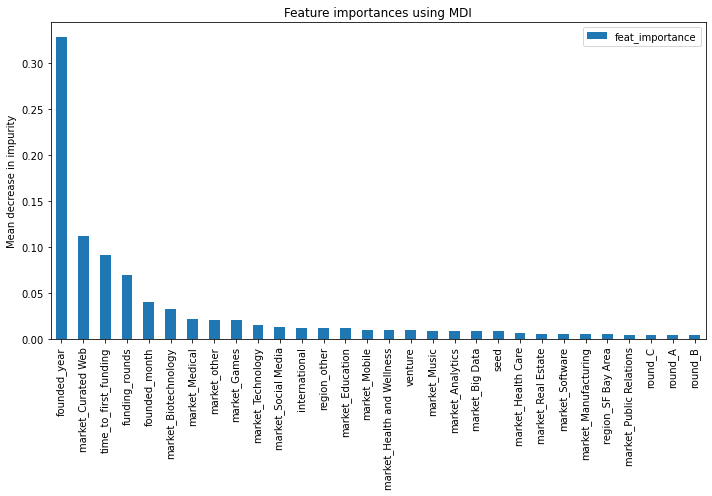

In [837]:
## Feature Selection

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, ext_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

#importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
#importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)
    
feats_df = pd.DataFrame(feats.items())

feats_df.columns = ['col', 'feat_importance']
feats_df = feats_df.sort_values(by=['feat_importance'], ascending=False)
feats_df_20 = feats_df[:20]
feats_df_30 = feats_df[:30]

fig, ax = plt.subplots(figsize = (10,7))
feats_df_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_df_30['col'])
fig.tight_layout()

### Gradient Boosted Models

#### XGBoost**

This model has best recall, but seems that is the case because we are casting a wide net. Accuracy and precision are sacrificed for the sake of boosting recall.

In [912]:
clf = XGBClassifier(random_state=42, max_depth=4, scale_pos_weight=50, 
                    min_child_weight=3, learning_rate=0.1, subsample= 0.7)
clf.fit(X_train_processed, y_train)

y_hat_train_clf = clf.predict(X_train_processed)
y_hat_test_clf = clf.predict(X_test_processed)

print(classification_report(y_train, y_hat_train_clf))
print(classification_report(y_test, y_hat_test_clf))
print_scores(y_train, y_hat_train_clf, y_test, y_hat_test_clf)

              precision    recall  f1-score   support

           0       1.00      0.60      0.75     24123
           1       0.13      0.98      0.22      1407

    accuracy                           0.62     25530
   macro avg       0.56      0.79      0.49     25530
weighted avg       0.95      0.62      0.72     25530

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      8024
           1       0.12      0.93      0.21       486

    accuracy                           0.61      8510
   macro avg       0.56      0.76      0.48      8510
weighted avg       0.94      0.61      0.71      8510

Training Recall:  0.9815209665955935
Testing Recall:  0.9300411522633745


Training F1:  0.22313782517369526
Testing F1:  0.21275594257472344


PR AUC:  0.11570898575511247


Training Accuracy:  0.6233450842146494
Testing Accuracy:  0.6069330199764983


Grid search for hyperparameter tuning

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_processed, y_train)

In [700]:
# setting up grid search
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4,6,8],
    'min_child_weight': [3,5,7],
    'subsample': [0.5, 0.7],
    'scale_pos_weight':[20,50,100]
}

In [ ]:
# Hypertuning parameters with Grid Search

In [701]:
grid_xgb = GridSearchCV(xgb, param_grid, cv = 5, scoring='recall') 
grid_xgb.fit(X_train_processed, y_train)

In [702]:
y_hat_train_xgb = grid_xgb.predict(X_train_processed)
y_hat_test_xgb = grid_xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train_xgb, y_test, y_hat_test_xgb)

Training Recall:  0.8933901918976546
Testing Recall:  0.8148148148148148


Training F1:  0.27797434763379036
Testing F1:  0.2549903412749517


PR AUC:  0.1337310094694761


Training Accuracy:  0.7442224833529182
Testing Accuracy:  0.7280846063454759


In [704]:
grid_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3,
 'scale_pos_weight': 20,
 'subsample': 0.7}

In [911]:
# Storing best performing model from grid search
# xgb_best = XGBClassifier(random_state=42, learning_rate=0.1, 
#                          max_depth= 4, min_child_weight= 7,
#                          scale_pos_weight= 100, subsample= 0.5)

xgb_best = XGBClassifier(random_state=42, learning_rate=0.1, 
                         max_depth= 4, min_child_weight= 3,
                         scale_pos_weight= 20, subsample= 0.7)

xgb_best.fit(X_train_processed, y_train)

y_hat_train_xgb_best = xgb_best.predict(X_train_processed)
y_hat_test_xgb_best = xgb_best.predict(X_test_processed)

print_scores(y_train, y_hat_train_xgb_best, y_test, y_hat_test_xgb_best)

Training Recall:  0.8862828713574982
Testing Recall:  0.8271604938271605


Training F1:  0.2755496630206607
Testing F1:  0.2581059390048154


PR AUC:  0.1363517287111975


Training Accuracy:  0.7431649040344692
Testing Accuracy:  0.7284371327849589


In [ ]:
# Feature importance using best model

In [841]:
f = 'gain' # importance type
feat_imp = xgb_best.get_booster().get_score(importance_type= f)
sorted(feat_imp.items(), key=lambda item: item[1], reverse=True)[:20]

[('founded_year', 215.02996173380004),
 ('funding_rounds', 211.90692118380005),
 ('time_to_first_funding', 149.1557620872671),
 ('market_Curated Web', 94.98529302222222),
 ('funding_total_usd', 85.35961955777476),
 ('international', 65.95872238333334),
 ('market_Enterprise Software', 64.97660825),
 ('round_C', 64.93544948),
 ('market_Advertising', 63.1362457),
 ('undisclosed', 63.124936116666674),
 ('market_Hardware + Software', 62.17092422500001),
 ('debt_financing', 59.25259103833336),
 ('market_Biotechnology', 58.582680679999996),
 ('market_Video', 57.4144745),
 ('round_D', 56.64323220000001),
 ('market_Analytics', 56.367070379999994),
 ('venture', 55.99698201000001),
 ('region_Denver', 55.9817276),
 ('market_Mobile', 55.62001216666666),
 ('market_other', 53.560516361)]

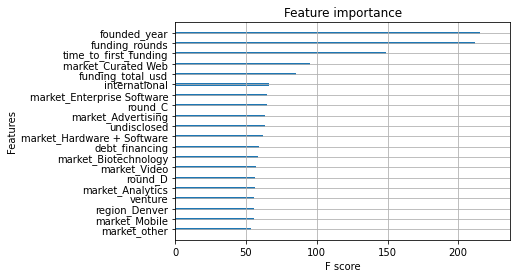

In [842]:
from xgboost import plot_importance
plot_importance(xgb_best, max_num_features=20, importance_type=f, 
                show_values=False)
plt.show()

## Feature Selection

In [ ]:
### In general, market seems to generate greater feature importance than region.
### Thus willing to do top 5 or 10 regions rather than top 40 and see if that
### reduces overfitting

In [162]:
from sklearn.feature_selection import SelectKBest, chi2

X_5_best= SelectKBest(chi2, k=20).fit(X_train_scaled, y_train)
mask = X_5_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, X_train_scaled.columns):
    if bool:
        new_feat.append(feature)
print('The best features are:{}'.format(new_feat)) # The list of your 5 best features

The best features are:['market_Analytics', 'market_Biotechnology', 'market_Curated Web', 'market_Education', 'market_Games', 'market_Health and Wellness', 'market_Medical', 'market_Messaging', 'market_Mobile', 'market_Music', 'market_Networking', 'market_Public Relations', 'market_Search', 'market_Social Media', 'market_Social Network Media', 'market_Technology', 'market_Video', 'market_other', 'funding_rounds', 'founded_year']


In [308]:
## long runtime

from sklearn.feature_selection import RFE
estimator = logreg3
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X_train_scaled, y_train)
rfe_mask = selector.get_support() #list of booleans for selected features

new_features = [] 
for bool, feature in zip(rfe_mask, X_train_scaled.columns):
    if bool:
        new_features.append(feature)

new_features # The list of your 5 best features

KeyboardInterrupt: 

## SMOTE With Best Model

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_processed, y_train) 

In [ ]:
final_model = DecisionTreeClassifier(random_state=42, 
                                     min_samples_leaf=15, max_depth=8, 
                                     criterion='entropy')

final_model.fit(X_train_resampled, y_train_resampled)

y_hat_train = final_model.predict(X_train_resampled)
y_hat_test = final_model.predict(X_test_processed)

print_scores(y_train_resampled, y_hat_train, y_test, y_hat_test)

## Final Model

In [ ]:
final_model = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                     min_samples_leaf=15, max_depth=8, 
                                     criterion='entropy')

final_model.fit(X_train_processed, y_train)

y_hat_train = final_model.predict(X_train_processed)
y_hat_test = final_model.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

# Acquired or Closed Dataset

In [1320]:
data_ac = df[df['status'] != 'operating']

## EDA / Preprocessing

In [1116]:
data_ac.isnull().sum()

name                       2
market                   611
funding_total_usd          1
status                  1315
country_code             835
state_code              2582
region                   835
city                     951
funding_rounds             1
founded_at              1720
founded_month           1725
founded_year            1725
first_funding_at           1
last_funding_at            1
seed                       1
venture                    1
equity_crowdfunding        1
undisclosed                1
convertible_note           1
debt_financing             1
angel                      1
grant                      1
private_equity             1
product_crowdfunding       1
round_A                    1
round_B                    1
round_C                    1
round_D                    1
round_E                    1
round_F                    1
round_G                    1
round_H                    1
dtype: int64

In [1057]:
len(data_ac)

7610

In [1321]:
data_ac = data_ac.dropna(subset=['status', 'name'])
len(data_ac)

6294

In [1322]:
data_ac['status'].value_counts(normalize=True)

acquired    0.58659
closed      0.41341
Name: status, dtype: float64

In [1323]:
# filling categoricals
data_ac = data_ac.fillna(value={'market': 'other', 'country_code': 'other', 
                                'region': 'other', 'city': 'other', 
                                'state_code': 'other'})

1st percentile of founded_year:  1982.0
Num Rows before 1980:  35


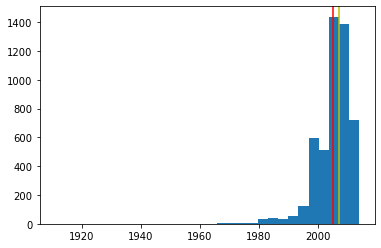

In [1324]:
# distribution of non NA years 
plt.hist(data_ac['founded_year'][~data_ac['founded_year'].isnull()], bins=30)
plt.axvline(x=np.nanmean(data_ac['founded_year']), color='r')
plt.axvline(x=np.nanmedian(data_ac['founded_year']), color='y')

p1 = np.percentile(data_ac['founded_year'][~data_ac['founded_year'].isnull()], 1)
print("1st percentile of founded_year: ", p1)

#1980 looks like a good cutoff point
print("Num Rows before 1980: ", len(data_ac[data_ac['founded_year'] < 1980]))
data_ac = data_ac[data_ac['founded_year'] >= 1980].reset_index(drop=True)

In [1325]:
data_ac['founded_at'] = [datetime.strptime(day, '%Y-%m-%d') for day \
                         in data_ac['founded_at'][~data_ac['founded_at'].isnull()]]
data_ac['first_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                               in data_ac['first_funding_at']]
data_ac['last_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                              in data_ac['last_funding_at']]
data_ac['founded_month'] = [datetime.strptime(mth, "%Y-%m").month for mth in data_ac['founded_month']]

In [1326]:
# imputing median for day, then pulling founded year and month from that
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

data_ac['founded_at'] = imp_median.fit_transform(data_ac[['founded_at']])

data_ac['founded_at'] = pd.to_datetime(data_ac['founded_at'])
data_ac['founded_year'] = [day.year for day in data_ac['founded_at']]
data_ac['founded_month'] = [day.month for day in data_ac['founded_at']]

In [1327]:
# creating column that labels country as domestic or international
data_ac['international'] = [0 if country=='USA' else 1 for country in data_ac['country_code']]

In [1328]:
# creating temporary columns to aid in calcuation of time to first funding

data_ac['founded_at_temp'] = [day.date() for day in data_ac['founded_at']]
data_ac['founded_at_temp'] = pd.to_datetime(data_ac['founded_at_temp'], 
                                            format = '%Y-%m-%d')

data_ac['first_funding_at_temp'] = pd.to_datetime(data_ac['first_funding_at'], 
                                                  format = '%Y-%m-%d', 
                                                  errors='coerce')
data_ac['last_funding_at_temp'] = pd.to_datetime(data_ac['last_funding_at'], 
                                                 format = '%Y-%m-%d', 
                                                 errors='coerce')

data_ac['time_to_first_funding'] = (data_ac['first_funding_at_temp'] - \
                                    data_ac['founded_at_temp']) / pd.Timedelta(days=365)

data_ac['time_first_to_last_funding'] = (data_ac['last_funding_at_temp'] - \
                                         data_ac['first_funding_at_temp']) / pd.Timedelta(days=365)

In [1329]:
# checking for nulls
print(data_ac['first_funding_at'][data_ac['time_to_first_funding'].isnull()])
print(data_ac['last_funding_at'][data_ac['time_first_to_last_funding'].isnull()])

3697    0011-11-14
Name: first_funding_at, dtype: object
3697    2012-07-24
Name: last_funding_at, dtype: object


In [1330]:
data_ac = data_ac.dropna(subset=['time_to_first_funding']).reset_index(drop=True)

Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Status)')

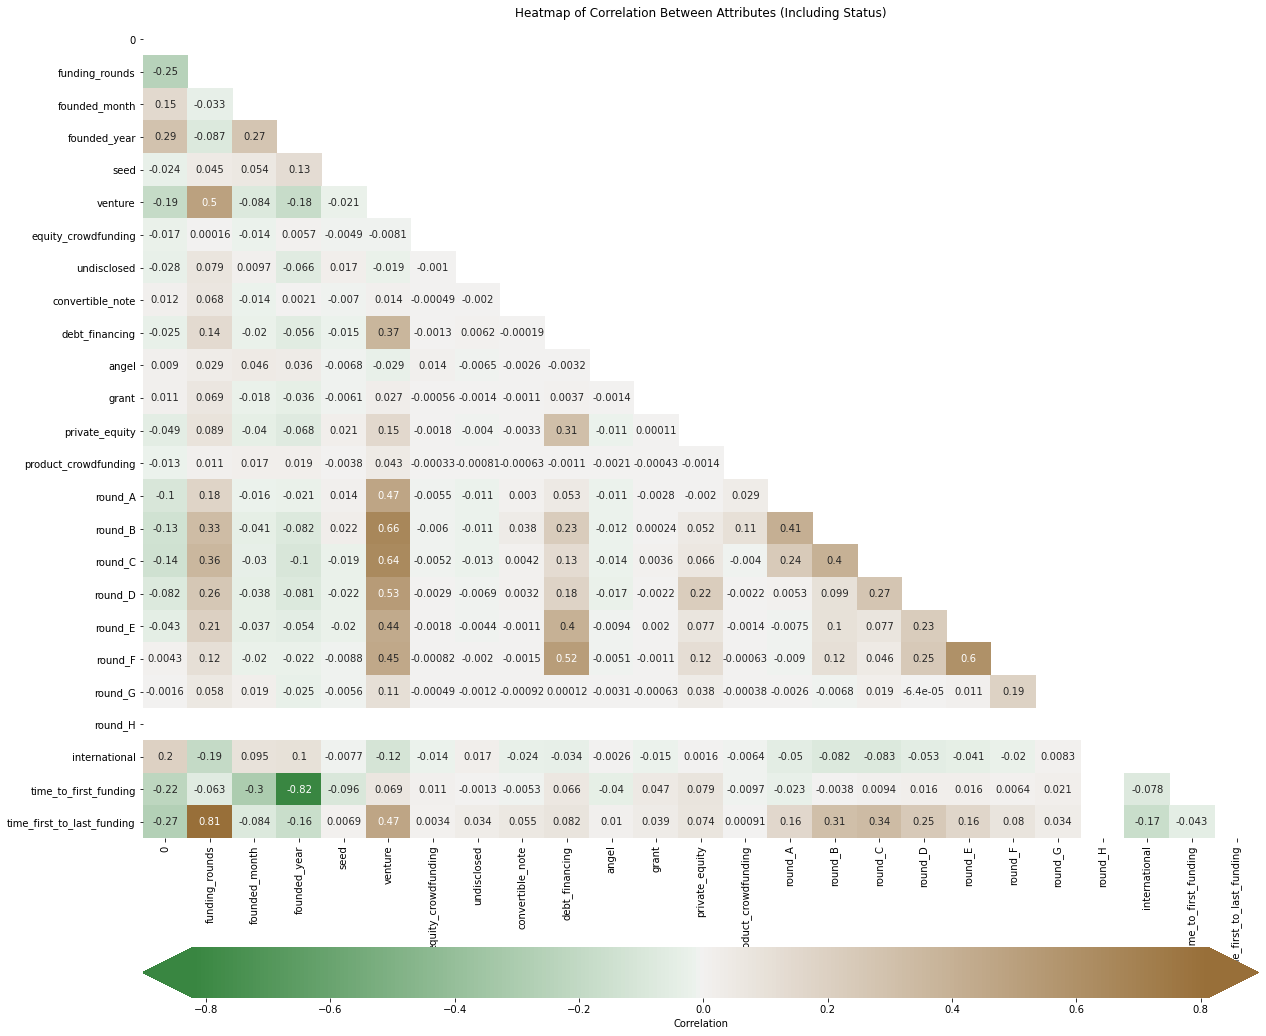

In [1331]:
# with status
encoder = LabelEncoder()
heatmap_data = pd.concat([pd.Series(encoder.fit_transform(data_ac['status'])), 
                          data_ac.drop('status', axis=1)], axis=1)

# without status
#heatmap_data = data.drop('status', axis=1)

h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Status)')

In [1332]:
#data_corr=data.drop(columns=['status'], axis=1).corr()
corr = h_corr.abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.set_index(['pairs'], inplace = True)
corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr.columns = ['cc']
corr.drop_duplicates(inplace=True)

corr[(corr['cc'] > 0.7) & (corr['cc'] < 1)]

,cc
pairs,
"(founded_year, time_to_first_funding)",0.819908
"(time_first_to_last_funding, funding_rounds)",0.812019


In [1333]:
# dropping correlated columns for logistic regression, which can be
# sensitive to correlated features
data_final = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                   'first_funding_at_temp', 'last_funding_at_temp', 
                                   'founded_at_temp', 'round_H', 'founded_year',  
                                   'time_first_to_last_funding'], 
                       axis=1)
# all inclusive
data_final2 = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                    'first_funding_at_temp', 'last_funding_at_temp', 
                                    'founded_at_temp', 'round_H'], 
                       axis=1)

In [1334]:
data_final.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding'],
      dtype='object')

In [1335]:
data_final2.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding', 'time_first_to_last_funding'],
      dtype='object')

## Train/Test Split

In [1382]:
X_ac_lr = data_final.drop(columns=['status', 'name', 'country_code', 
                                   'state_code', 'city'], axis=1)

encoder = LabelEncoder()
y_ac_lr = pd.Series(encoder.fit_transform(data_final['status'])) 
# acquired is 0, closed is 1

y_ac_lr.value_counts(normalize=True)

0    0.59716
1    0.40284
dtype: float64

In [1383]:
X_ac = data_final2.drop(columns=['status', 'name', 'country_code', 'state_code', 
                             'city'], axis=1)

encoder = LabelEncoder()
y_ac = pd.Series(encoder.fit_transform(data_final2['status'])) 
# acquired is 0, closed is 1

y_ac.value_counts(normalize=True)

0    0.59716
1    0.40284
dtype: float64

## Baseline Model

In [1384]:
X_train_processed, X_train_scaled, X_test_processed, \
X_test_scaled, y_train, y_test = train_test_preprocess(X_ac_lr, y_ac_lr)

In [1385]:
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [1386]:
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6281102891728312
Testing Recall:  0.5410821643286573


Training F1:  0.6867647058823528
Testing F1:  0.5831533477321813


ROC AUC:  0.6635928532814948
PR AUC:  0.5278621350158945


Training Accuracy:  0.7695428725994049
Testing Accuracy:  0.6869424168694241


### Baseline Analysis

* point A
* point B
* point C

### Grid Search on Baseline

In [1102]:
param_grid = {'penalty':['l2', None],
              'solver':['lbfgs', 'sag'],
              'C': [1.0, 1e12], 
              'class_weight': [None, 'balanced']
             }

In [1103]:
grid_logreg = GridSearchCV(baseline_model, param_grid, cv = 5, 
                           scoring='recall') # macro or weighted
grid_logreg.fit(X_train_scaled, y_train)
grid_logreg.best_params_

{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}

In [1105]:
y_preds_grid_lr_train = grid_logreg.predict(X_train_scaled)
y_preds_grid_lr = grid_logreg.predict(X_test_scaled)

print_scores(y_train, y_preds_grid_lr_train, y_test, y_preds_grid_lr)

Training Recall:  0.7612642905178211
Testing Recall:  0.685370741482966


Training F1:  0.7070580886945658
Testing F1:  0.631578947368421


ROC AUC:  0.677835234501701
PR AUC:  0.5286960838540951


Training Accuracy:  0.7462807681904247
Testing Accuracy:  0.6763990267639902


## Custom Pipeline

In [1387]:
scores = pd.DataFrame(columns = ['recall_train', 'recall_test', 'f1_train', 
                                 'f1_test', 'accuracy_train', 'accuracy_test', 
                                 'roc_auc', 'pr_auc', 'params'])

In [1388]:
# creates a data frame with various scores for each model
def customPipe(model, model_name, X, y):
    X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
    y_train, y_test = train_test_preprocess(X, y)
    
    if ('lr' in model_name) | ('knn' in model_name):
    #(model_name == 'lr') | (model_name == 'knn'):
        model.fit(X_train_scaled, y_train)
        y_hat_train = model.predict(X_train_scaled)
        y_hat_test = model.predict(X_test_scaled)

    else:
        model.fit(X_train_processed, y_train)
        y_hat_train = model.predict(X_train_processed)
        y_hat_test = model.predict(X_test_processed)
    
    r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc = \
    return_scores(y_train, y_hat_train, y_test, y_hat_test)
    
    score_list = []
    score_list.extend((r_train, r_test, f1_train, f1_test, 
                       ac_train, ac_test, roc_auc, pr_auc, str(model)))
    
    scores.loc[model_name] = score_list
    return scores

In [1389]:
# model inputs
lr = LogisticRegression(random_state=42, class_weight='balanced', solver='sag')
rf = RandomForestClassifier(random_state=42)
dtc = DecisionTreeClassifier(random_state=42)
ext = ExtraTreesClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
knn = KNeighborsClassifier()

In [1241]:
# lr = LogisticRegression(random_state=42, class_weight='balanced')
# rf = RandomForestClassifier(random_state=42, class_weight='balanced', 
#                             criterion='gini', min_samples_leaf=10, max_depth=5)
# dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced',
#                              min_samples_leaf=15, max_depth=8, criterion='entropy')
# ext = ExtraTreesClassifier(random_state=42)
# xgb = XGBClassifier(random_state=42)

In [1390]:
# running the function
customPipe(lr, 'lr_base', X_ac_lr, y_ac_lr)
customPipe(rf, 'rf', X_ac, y_ac)
customPipe(dtc, 'dtc', X_ac, y_ac)
customPipe(ext, 'ext', X_ac, y_ac)
customPipe(xgb, 'xgb', X_ac, y_ac)
customPipe(knn, 'knn', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.761264,0.685371,0.707058,0.631579,0.746281,0.676399,0.677835,0.528696,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.629259,1.000000,0.668085,1.000000,0.746959,0.728117,0.598084,RandomForestClassifier(random_state=42)
dtc,1.000000,0.573146,1.000000,0.569721,1.000000,0.649635,0.637391,0.497343,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.567134,1.000000,0.608602,1.000000,0.704785,0.682750,0.547570,ExtraTreesClassifier(random_state=42)
xgb,0.903161,0.621242,0.904073,0.640496,0.922910,0.717762,0.702311,0.563914,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.693342,0.563126,0.713989,0.577002,0.776576,0.665856,0.649411,0.509938,KNeighborsClassifier()


Looking at recall and accuracy, the Random Forest and XGBoost models seem to yield the best scores. Will hyper tune each of these models.

In [1391]:
# storing dataframe for easy access
scores_base = scores # models pre hyper parameter tuning

## Other Models - Hypertuning

### Random Forest**

In [1392]:
rf = RandomForestClassifier(random_state=42)

# Initial search
rf_param_grid = {
    'criterion':['gini','entropy','log_loss'],
    'max_depth':[3,8,12],
    'min_samples_leaf': [5,10],
    'class_weight': [None, 'balanced']
}

# Fine tuning
rf_param_grid2 = {
    'criterion':['gini'],
    'max_depth':[12,20],
    'min_samples_leaf': [1,5,10],
    'class_weight': ['balanced'],
    'n_estimators': [100, 200, 500]
}

grid_rfc = GridSearchCV(rf, rf_param_grid2, cv = 5, scoring='recall') 
grid_rfc.fit(X_train_processed, y_train)

grid_rfc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 10,
 'n_estimators': 100}

In [1393]:
rf_best = RandomForestClassifier(random_state = 42, class_weight='balanced', 
                                 criterion='gini', max_depth=20, #12
                                 min_samples_leaf=10, n_estimators=100) #100
customPipe(rf_best, 'rf_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.761264,0.685371,0.707058,0.631579,0.746281,0.676399,0.677835,0.528696,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.629259,1.000000,0.668085,1.000000,0.746959,0.728117,0.598084,RandomForestClassifier(random_state=42)
dtc,1.000000,0.573146,1.000000,0.569721,1.000000,0.649635,0.637391,0.497343,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.567134,1.000000,0.608602,1.000000,0.704785,0.682750,0.547570,ExtraTreesClassifier(random_state=42)
xgb,0.903161,0.621242,0.904073,0.640496,0.922910,0.717762,0.702311,0.563914,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.693342,0.563126,0.713989,0.577002,0.776576,0.665856,0.649411,0.509938,KNeighborsClassifier()
rf_best,0.737727,0.747495,0.692551,0.696545,0.736543,0.736415,0.738189,0.589630,RandomForestClassifier(class_weight='balanced'...


#### Feature Importance

In [1417]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, rf_grid.feature_importances_):
    feats[feature] = importance #add the name/value pair 

feats_rf = pd.DataFrame(feats.items())

feats_rf.columns = ['col', 'feat_importance']
feats_rf = feats_rf.sort_values(by=['feat_importance'], ascending=False)
feats_rf_20 = feats_rf[:20]
feats_rf_30 = feats_rf[:30]

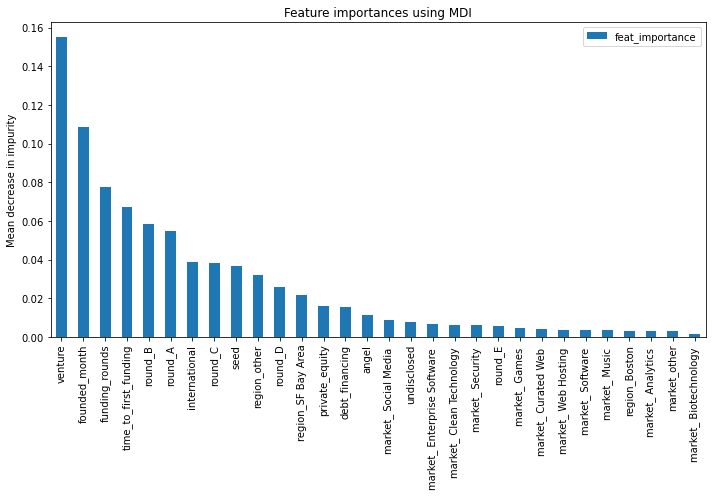

In [1418]:
fig, ax = plt.subplots(figsize = (10,7))
feats_df_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_rf_30['col'])
fig.tight_layout()

In [1420]:
list(feats_rf['col'][:10])

['venture',
 'founded_month',
 'funding_rounds',
 'time_to_first_funding',
 'round_B',
 'round_A',
 'international',
 'round_C',
 'seed',
 'region_other']

### XG Boost**

In [1303]:
# 45+ runtime
xgb = XGBClassifier(random_state=42)

# initial grid search
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4,6,8],
    'min_child_weight': [3,5,7],
    'subsample': [0.5, 0.7],
    'scale_pos_weight':[1.5,2]
}

# fine tuning
xgb_param_grid2 = {
    'learning_rate': [0.1],
    'max_depth': [1,2,4],
    'min_child_weight': [1,5,10],
    'subsample': [0.7, 0.9],
    'scale_pos_weight':[2]
}

grid_xgb = GridSearchCV(xgb, xgb_param_grid2, cv = 5, scoring='recall') 
grid_xgb.fit(X_train_processed, y_train)

grid_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'scale_pos_weight': 1.5,
 'subsample': 0.7}

In [1406]:
xgb_best = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                         subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

customPipe(xgb_grid, 'xgb_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.761264,0.685371,0.707058,0.631579,0.746281,0.676399,0.677835,0.528696,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.629259,1.000000,0.668085,1.000000,0.746959,0.728117,0.598084,RandomForestClassifier(random_state=42)
dtc,1.000000,0.573146,1.000000,0.569721,1.000000,0.649635,0.637391,0.497343,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.567134,1.000000,0.608602,1.000000,0.704785,0.682750,0.547570,ExtraTreesClassifier(random_state=42)
xgb,0.903161,0.621242,0.904073,0.640496,0.922910,0.717762,0.702311,0.563914,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.693342,0.563126,0.713989,0.577002,0.776576,0.665856,0.649411,0.509938,KNeighborsClassifier()
rf_best,0.737727,0.747495,0.692551,0.696545,0.736543,0.736415,0.738189,0.589630,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.811029,0.803607,0.706089,0.692573,0.728428,0.711273,0.726054,0.568474,"XGBClassifier(base_score=0.5, booster='gbtree'..."


#### Feature Importance

In [1408]:
xgb_best.fit(X_train_processed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=1,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1422]:
f = 'gain' # importance type
feat_imp = xgb_best.get_booster().get_score(importance_type= f)
feats_xg = pd.DataFrame(sorted(feat_imp.items(), key=lambda item: item[1], 
                            reverse=True))
feats_xg.columns = ['col', 'feat_importance']
feats_xg[:15]

,col,feat_importance
0,venture,137.955549
1,international,39.561854
2,time_to_first_funding,39.424174
3,funding_rounds,38.831849
4,region_SF Bay Area,28.985225
5,round_B,24.459665
6,market_other,21.060514
7,seed,20.188928
8,market_ Clean Technology,19.559940
9,market_ Biotechnology,18.870132


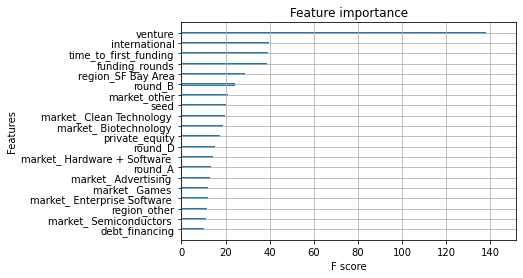

In [1423]:
from xgboost import plot_importance
plot_importance(xgb_best, max_num_features=20, importance_type=f, 
                show_values=False)
plt.show()

### ExtraTrees

In [1272]:
ext_param_grid = {'criterion':['gini','entropy','log_loss'],
              'max_depth':[5,10,15],
              'min_samples_leaf': [5,10],
              'class_weight': [None, 'balanced'],
              'max_features': ['auto']
             }

ext = ExtraTreesClassifier(random_state=42)

grid_ext = GridSearchCV(ext, ext_param_grid, cv = 5, scoring='recall') 
grid_ext.fit(X_train_processed, y_train)

grid_ext.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 5}

In [1359]:
ext_grid = ExtraTreesClassifier(random_state=42, class_weight='balanced',
                                criterion='entropy', max_depth= 15,
                                max_features='auto', min_samples_leaf= 5)
customPipe(ext_grid, 'ext_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.628110,0.541082,0.686765,0.583153,0.769543,0.686942,0.663593,0.527862,LogisticRegression(random_state=42)
rf,1.000000,0.629259,1.000000,0.668085,1.000000,0.746959,0.728117,0.598084,RandomForestClassifier(random_state=42)
dtc,1.000000,0.573146,1.000000,0.569721,1.000000,0.649635,0.637391,0.497343,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.567134,1.000000,0.608602,1.000000,0.704785,0.682750,0.547570,ExtraTreesClassifier(random_state=42)
xgb,0.903161,0.621242,0.904073,0.640496,0.922910,0.717762,0.702311,0.563914,"XGBClassifier(base_score=0.5, booster='gbtree'..."
rf_best,0.733020,0.725451,0.678916,0.669131,0.721125,0.709651,0.712180,0.561563,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.995965,0.949900,0.656908,0.631579,0.581553,0.551500,0.615277,0.469630,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.693342,0.563126,0.713989,0.577002,0.776576,0.665856,0.649411,0.509938,KNeighborsClassifier()
ext_best,0.706792,0.649299,0.673502,0.623077,0.724371,0.682076,0.676829,0.530789,"ExtraTreesClassifier(class_weight='balanced', ..."
dtc_best,0.733692,0.635271,0.723715,0.632735,0.774682,0.701541,0.690932,0.547967,DecisionTreeClassifier(class_weight='balanced'...


### Decision Tree

In [1277]:
dtc_param_grid = {'criterion':['gini','entropy'],
                  'max_depth':[5,10,15],
                  'min_samples_leaf': [1,5,10,15],
                  'class_weight': [None, 'balanced']
             }

dtc = DecisionTreeClassifier(random_state=42)

grid_dtc = GridSearchCV(dtc, dtc_param_grid, cv = 5, scoring='average_precision') 
grid_dtc.fit(X_train_processed, y_train)

grid_dtc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 15}

In [1358]:
dtc_grid = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                  criterion='gini', max_depth= 10,
                                  min_samples_leaf= 15)
customPipe(dtc_grid, 'dtc_test', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.628110,0.541082,0.686765,0.583153,0.769543,0.686942,0.663593,0.527862,LogisticRegression(random_state=42)
rf,1.000000,0.629259,1.000000,0.668085,1.000000,0.746959,0.728117,0.598084,RandomForestClassifier(random_state=42)
dtc,1.000000,0.573146,1.000000,0.569721,1.000000,0.649635,0.637391,0.497343,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.567134,1.000000,0.608602,1.000000,0.704785,0.682750,0.547570,ExtraTreesClassifier(random_state=42)
xgb,0.903161,0.621242,0.904073,0.640496,0.922910,0.717762,0.702311,0.563914,"XGBClassifier(base_score=0.5, booster='gbtree'..."
rf_best,0.733020,0.725451,0.678916,0.669131,0.721125,0.709651,0.712180,0.561563,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.995965,0.949900,0.656908,0.631579,0.581553,0.551500,0.615277,0.469630,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.693342,0.563126,0.713989,0.577002,0.776576,0.665856,0.649411,0.509938,KNeighborsClassifier()
ext_best,0.670477,0.621242,0.653128,0.609636,0.713552,0.678021,0.668932,0.525071,"ExtraTreesClassifier(class_weight='balanced', ..."
dtc_best,0.733692,0.635271,0.723715,0.632735,0.774682,0.701541,0.690932,0.547967,DecisionTreeClassifier(class_weight='balanced'...


## Final Model

* XG Boost is the best model, with ~80% recall, 70% accuracy and 70% AUC
* Random Forest comes in second with --
* Now that we have narrowed down the best models, we will run then with reduced features & SMOTE to see if that generates any improvement

In [1424]:
X_train_processed, X_train_scaled, X_test_processed, \
X_test_scaled, y_train, y_test = train_test_preprocess(X_ac, y_ac)

### Feature Reduction

In [1431]:
# top 20 features
X_train_xg = X_train_processed[list(feats_xg['col'][:20])]
X_train_rf = X_train_processed[list(feats_rf['col'][:20])]

X_test_xg = X_test_processed[list(feats_xg['col'][:20])]
X_test_rf = X_test_processed[list(feats_rf['col'][:20])]

In [ ]:
# XG Boost
final_model = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                            subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

final_model.fit(X_train_xg, y_train)

y_hat_train = final_model.predict(X_train_xg)
y_hat_test = final_model.predict(X_test_xg)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [1432]:
# Random Forest - 2nd place
final_model = RandomForestClassifier(random_state = 42, class_weight='balanced', 
                                     criterion='gini', max_depth=20,
                                     min_samples_leaf=10, n_estimators=100)
final_model.fit(X_train_rf, y_train)

y_hat_train = final_model.predict(X_train_rf)
y_hat_test = final_model.predict(X_test_rf)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7330195023537324
Testing Recall:  0.6973947895791583


Training F1:  0.7131174353941774
Testing F1:  0.6770428015564203


ROC AUC:  0.7254003920647836
PR AUC:  0.5812431999837235


Training Accuracy:  0.7627806329456316
Testing Accuracy:  0.7307380373073804


Feature reduction doesn't improve the models.

### SMOTE

In [1379]:
#Using SMOTE to further reduce class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_processed, y_train) 

In [1376]:
final_model_smote = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                                  subsample=0.7, learning_rate=0.2)

final_model_smote.fit(X_train_resampled, y_train_resampled)

y_hat_train = final_model_smote.predict(X_train_resampled)
y_hat_test = final_model_smote.predict(X_test_processed)

print_scores(y_train_resampled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7515837104072398
Testing Recall:  0.717434869739479


Training F1:  0.7538007714998864
Testing F1:  0.6878001921229587


ROC AUC:  0.7333768354146988
PR AUC:  0.5882328757316215


Training Accuracy:  0.754524886877828
Testing Accuracy:  0.7364152473641524


### Model Selection

In [1435]:
final_model = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                            subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

customPipe(final_model, 'final_model', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.761264,0.685371,0.707058,0.631579,0.746281,0.676399,0.677835,0.528696,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.629259,1.000000,0.668085,1.000000,0.746959,0.728117,0.598084,RandomForestClassifier(random_state=42)
dtc,1.000000,0.573146,1.000000,0.569721,1.000000,0.649635,0.637391,0.497343,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.567134,1.000000,0.608602,1.000000,0.704785,0.682750,0.547570,ExtraTreesClassifier(random_state=42)
xgb,0.903161,0.621242,0.904073,0.640496,0.922910,0.717762,0.702311,0.563914,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.693342,0.563126,0.713989,0.577002,0.776576,0.665856,0.649411,0.509938,KNeighborsClassifier()
rf_best,0.737727,0.747495,0.692551,0.696545,0.736543,0.736415,0.738189,0.589630,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.811029,0.803607,0.706089,0.692573,0.728428,0.711273,0.726054,0.568474,"XGBClassifier(base_score=0.5, booster='gbtree'..."
final_model,0.814391,0.813627,0.709432,0.692242,0.731674,0.707218,0.724252,0.565534,"XGBClassifier(base_score=0.5, booster='gbtree'..."


In [1436]:
# storing dataframe for easy access
scores_final = scores
scores_final.to_csv('final_scores.csv')

# Appendix - Extra

In [ ]:
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression())
])

pipe.fit(X_train, y_train)

In [ ]:
# Replace FireplaceQu NaNs with "N/A"s
#X_test["FireplaceQu"] = X_test["FireplaceQu"].fillna("N/A")

# Add missing indicator for lot frontage
#frontage_test = X_test[["LotFrontage"]]
#frontage_missing_test = missing_indicator.transform(frontage_test)
#X_test["LotFrontage_Missing"] = frontage_missing_test

# Impute missing lot frontage values
#frontage_imputed_test = imputer.transform(frontage_test)
#X_test["LotFrontage"] = frontage_imputed_test

# Check that there are no more missing values
#X_test.isna().sum()

In [ ]:
# Scale continuous values using MinMaxScaler
scaler = MinMaxScaler()
X_train_cont = scaler.fit_transform(X_train_cont)
X_test_cont = scaler.transform(X_test_cont)

# Dummy encode categorical values using OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train_cat)
X_test_cat = ohe.transform(X_test_cat)

# Combine everything back together
X_train_preprocessed = np.concatenate([X_train_cont, X_train_cat.todense()], axis=1)
X_test_preprocessed = np.concatenate([X_test_cont, X_test_cat.todense()], axis=1)

In [679]:
cat_columns = ['market', 'region'] #, 'founded_quarter']

cat_train = X_train[cat_columns].reset_index(drop=True)
cat_test = X_test[cat_columns].reset_index(drop=True)

ohe = OneHotEncoder(handle_unknown = 'ignore')

encoded_train = ohe.fit_transform(cat_train).toarray()

X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

X_train_processed = pd.concat([X_train_cat, X_train_cont, X_train_cat_eng], axis=1)
X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled, X_train_cat_eng], axis=1) 

display(X_train_processed.head())
X_train_scaled.head()

In [ ]:
selector = VarianceThreshold()
reduced_feature_train = pd.DataFrame(selector.fit_transform(X_train_processed), 
                                     columns=X_poly_train.columns, 
                                     index=X_train_processed.index)


#reduced_feature_test = pd.DataFrame(selector.transform(X_poly_test), columns=X_poly_test.columns, index=X_poly_test.index)

In [ ]:
selector = SelectKBest(score_func=f_classif)
X_k_best_train = selector.fit_transform(X_poly_train, y_train)
X_k_best_test = selector.transform(X_poly_test)

In [ ]:

#baseline_model.score

# Use cross_val_score with scoring="neg_log_loss" to evaluate the model
# on X_train and y_train
#baseline_neg_log_loss_cv = cross_val_score(baseline_model, X_train, y_train, scoring="neg_log_loss")

#baseline_log_loss = -(baseline_neg_log_loss_cv.mean())
#baseline_log_loss

In [98]:
## WHAT IS THIS SAYING??
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print('------------------------------------')
print(pd.Series(residuals).value_counts(normalize=True))
#print(classification_report(y_test, y_hat_test))

0    31427
2     2758
1     1907
dtype: int64
------------------------------------
0    0.870747
2    0.076416
1    0.052837
dtype: float64


In [ ]:
## source: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

# Function to calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

X=df.drop(['Salary'],axis=1)
calculate_vif(X)

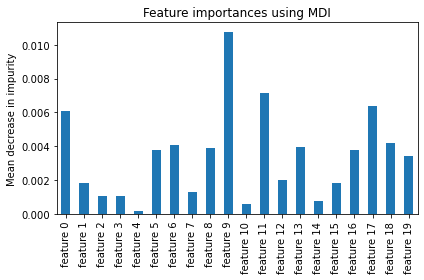

In [166]:
importances = rfc.feature_importances_[:20]
feature_names = [f"feature {i}" for i in range(X_train_processed.shape[1])][:20]
forest_importances = pd.Series(importances, index=feature_names)[:20]
#std = np.std([rfc.feature_importances_ for tree in rfc.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [604]:
# need to do this in command line
# brew install libomp 
# https://stackoverflow.com/questions/44937698/lightgbm-oserror-library-not-loaded
import neptune.new as neptune
 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#import lightgbm

MODEL_PARAMS = {'random_state': 42,
                'learning_rate': 0.1,
                'n_estimators': 200, 
                'scale_pos_weight': 100}

# Train model
model = lightgbm.LGBMClassifier(**MODEL_PARAMS)
model.fit(X_train_processed, y_train)

# Evaluate model
y_test_pred = model.predict_proba(X_test_processed)
y_train_pred = model.predict_proba(X_train_processed)

print_scores(y_train, y_train_pred, y_test, y_test_pred)

ERROR: Could not find a version that satisfies the requirement neptune (from versions: none)
ERROR: No matching distribution found for neptune
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'neptune'

In [1144]:
pipe = Pipeline(steps=[
    ("lr", LogisticRegression(random_state=42, class_weight=)),
    #("dt", DecisionTreeClassifier(random_state=42))
])

# Use the pipeline to fit the model and score it
pipe.fit(X_train_processed, y_train)
pipe.score(X_test_processed, y_test)

AttributeError: 'Pipeline' object has no attribute 'recall_score'